In [1]:
import warnings
warnings.filterwarnings('ignore')

# Load NeuroKit and other useful packages
import os
import neurokit2 as nk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]  # Bigger images

In [2]:
data = np.load('sample-data/0004.npy')
data = np.squeeze(data)
print(data.ndim)
print(type(data))
print(len(data))
print((data))
data.dtype

1
<class 'numpy.ndarray'>
150000
[ 0.06489671  0.07794824  0.0524531  ... -0.03651389 -0.07684636
 -0.10294943]


dtype('float32')

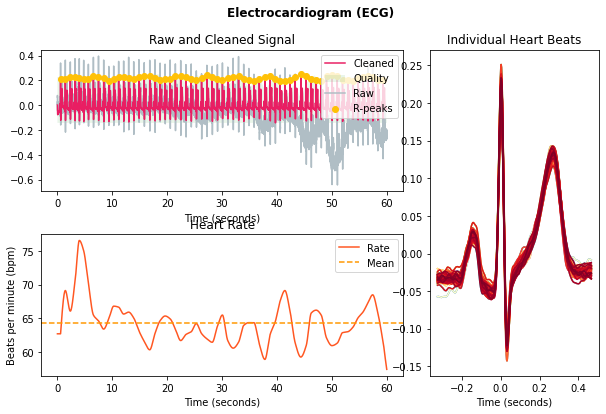

In [3]:
# Process ecg for 1 Person TODO: for-loop
ecg_signals, info = nk.ecg_process(data, sampling_rate=500)
plot = nk.ecg_plot(ecg_signals[:30000], sampling_rate=500)

<class 'dict'>


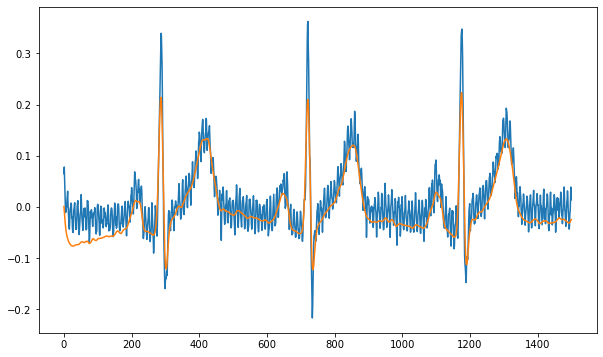

In [4]:
# nk.ecg_intervalrelated(ecg_signals)
print(type(info))

ecg_raw = ecg_signals["ECG_Raw"]
ecg_clean = ecg_signals["ECG_Clean"]
plt.plot(ecg_raw[:1500])
plt.plot(ecg_clean[:1500])

In [5]:
print(len(ecg_clean))
print(type(ecg_clean))
ecg_clean = np.float32(ecg_clean)
ecg_clean.dtype

#ecg_clean.to_csv('data.csv')  

150000
<class 'pandas.core.series.Series'>


dtype('float32')

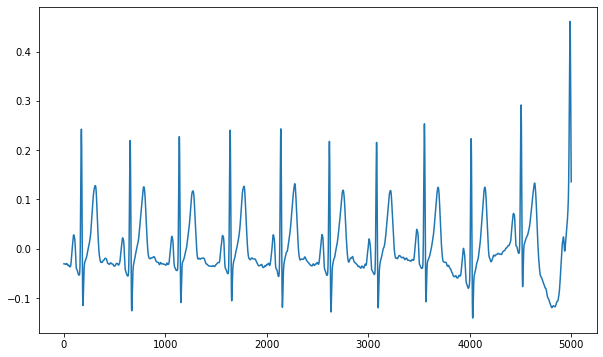

In [6]:
ecg_clean.ndim
plt.plot(ecg_clean[145000:])

In [7]:
#03 keras

In [8]:
# for Tensorflow:

import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [9]:
tf.version.VERSION

'2.3.0'

In [10]:
# Code from Brownlee 2018

# univariate multi-step vector-output stacked lstm example
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

In [11]:
ecg = ecg_clean[5000:55000] # nur mit Untermenge auf Laptop
ecg.ndim
ecg.shape
#plt.plot(ecg)
print(type(ecg))
print(ecg)
ecg.dtype
ecg.shape

<class 'numpy.ndarray'>
[-0.03642879 -0.03586905 -0.03535685 ... -0.03099178 -0.03079937
 -0.03067833]


(50000,)

In [12]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        if i % 500 == 0: # to reduce redundancy
            # find the end of this pattern
            end_ix = i + n_steps_in
            out_end_ix = end_ix + n_steps_out
            # check if we are beyond the sequence
            if out_end_ix > len(sequence):
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
            X.append(seq_x)
            y.append(seq_y)
    return array(X), array(y)

# choose a number of time steps
n_steps_in, n_steps_out = 3*500, 1*500
# split into samples
X, y = split_sequence(ecg, n_steps_in, n_steps_out)
# summarize the data
print(len(ecg))
print(X.shape,y.shape)

50000
(97, 1500) (97, 500)


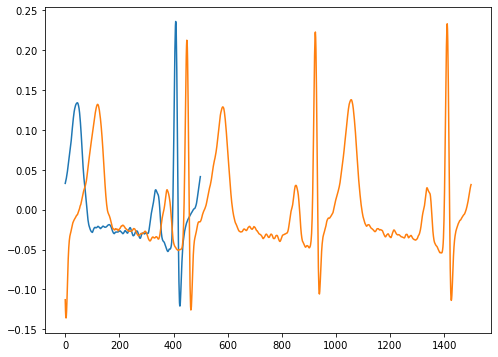

In [13]:
test = y[3,:]
plt.plot(test)
plt.plot(X[3,:])
#test2 = nk.signal_smooth(test, method='convolution', kernel='boxzen', size=10, alpha=0.1)
#plt.plot(test2)


In [14]:
# 3D-Data. X = Input, y = output

# "The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features]"
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
print(X.shape,y.shape)
#plt.plot(y[3,:,0])
print(type(X))

(97, 1500, 1) (97, 500, 1)
<class 'numpy.ndarray'>


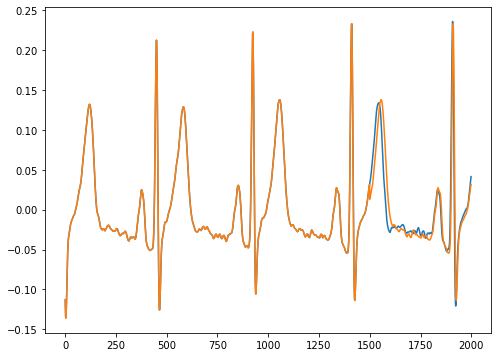

In [15]:
test = np.append(X[3,:,0], y[3,:,0])
test2 = np.append(X[3,:,0], y[2,:,0])
plt.plot(test)
plt.plot(test2)

In [28]:
# Data split
print(X.shape,y.shape)

num_train_samples = int(0.5 * len(X))
num_val_samples = int(0.25 * len(X))
num_test_samples = len(X) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_vali =  X[num_train_samples:(num_train_samples+num_val_samples)]
y_vali = y[num_train_samples:(num_train_samples+num_val_samples)]
X_test = X[(num_train_samples+num_val_samples):]
y_test = y[(num_train_samples+num_val_samples):]

print(len(X_train))
print(len(X_vali))
print(len(X_test))

(97, 1500, 1) (97, 500, 1)
num_train_samples: 48
num_val_samples: 24
num_test_samples: 25
48
24
25


In [29]:
# define model
model = Sequential()
model.add(LSTM(300, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse', metrics=["mae"]) # accuracy does not work

In [30]:
# fit model
history = model.fit(X_train, y_train, epochs=4, batch_size=4, verbose=1, validation_data=(X_vali, y_vali))

Epoch 1/4
12/12 [==============================] - 37s 3s/step - loss: 0.0031 - mae: 0.0414 - val_loss: 0.0032 - val_mae: 0.0420
Epoch 2/4
12/12 [==============================] - 35s 3s/step - loss: 0.0031 - mae: 0.0411 - val_loss: 0.0032 - val_mae: 0.0419
Epoch 3/4
12/12 [==============================] - 40s 3s/step - loss: 0.0031 - mae: 0.0409 - val_loss: 0.0032 - val_mae: 0.0418
Epoch 4/4
12/12 [==============================] - 45s 4s/step - loss: 0.0031 - mae: 0.0407 - val_loss: 0.0032 - val_mae: 0.0417


In [31]:
history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

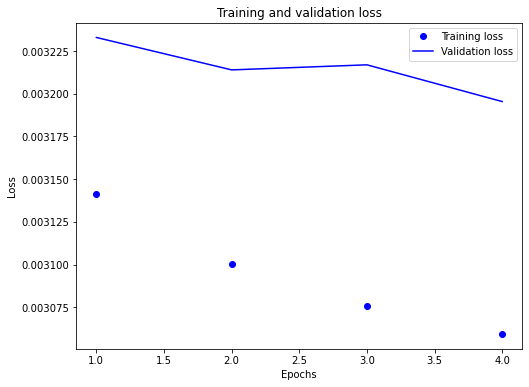

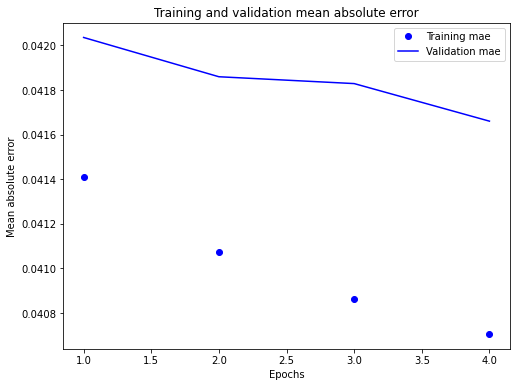

In [32]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.clf()
mae = history_dict["mae"]
val_mae = history_dict["val_mae"]
plt.plot(epochs, mae, "bo", label="Training mae")
plt.plot(epochs, val_mae, "b", label="Validation mae")
plt.title("Training and validation mean absolute error")
plt.xlabel("Epochs")
plt.ylabel("Mean absolute error")
plt.legend()
plt.show()

In [37]:
print(X_test[1,:,:])
X_test[1].shape

[[-0.03268497]
 [-0.03664774]
 [-0.03973256]
 ...
 [ 0.05889203]
 [ 0.06158496]
 [ 0.06423648]]


(1500, 1)

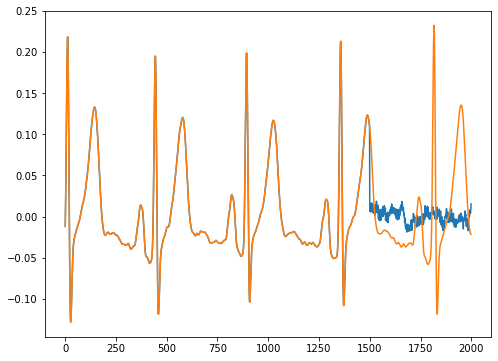

In [42]:
# demonstrate prediction
yhat = model.predict(X_test,batch_size=10)
test = np.append(X_test[2],yhat[2])
test2 = np.append(X_test[2],y_test[2])

plt.plot(test)
plt.plot(test2)